In [4]:
import ehrapy as ep
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

adata = ep.io.read_h5ad("../../anndata_objects/adata_02_2023_pneumonia_unspecified_rest.h5ad")

In [5]:
ep.tl.leiden(adata, resolution=0.6, key_added="leiden_0_6")
#"2": "severe bacterial pneumonia with fungal co-infection",
#"0": "viral pneumonia, mild course",   
#"3": "sepsis",
#"1": "mild bacterial pneumonia" 

In [6]:
adata_viral = adata[adata.obs['leiden_0_6'].isin(['0']),:]
adata_mild_b = adata[adata.obs['leiden_0_6'].isin(['1']),:]
adata_severe_b = adata[adata.obs['leiden_0_6'].isin(['2']),:]
adata_sepsis = adata[adata.obs['leiden_0_6'].isin(['3']),:]

In [9]:
preprocessed_df = pd.read_csv("../../data_pp_notebooks/temp_pp_data_files/data_02_2023_NEW.csv")
lab_vals = pd.read_csv("../../V1.1.0/LABEVENTS.csv")

def daily_lab_value(adata_, id_) -> pd.DataFrame:
    hadm_cluster = preprocessed_df[preprocessed_df['HADM_ID'].isin(list(adata_.obs["HADM_ID"]))]
    hadm_cluster = hadm_cluster[["SUBJECT_ID", "HADM_ID","ICUSTAY_ID", "INTIME", "OUTTIME", "LOS"]]
    all_lab_probes = lab_vals[lab_vals['ITEMID'].isin([id_])]
    cluster_lab_probes = all_lab_probes[all_lab_probes['HADM_ID'].isin(list(hadm_cluster["HADM_ID"]))]
    # extract dates only, since we operate on a per day basis
    cluster_lab_probes['probe_date'] = pd.to_datetime(cluster_lab_probes['CHARTTIME']).dt.date
    cluster_lab_probes.drop(["ROW_ID", "ITEMID", "VALUE", "VALUEUOM", "CHARTTIME"], axis=1, inplace=True)
    # average on a per day basis per hadm 
    # TODO: Take most extreme value???? like the one that differs most from mean of ref range
    cluster_lab_probes = cluster_lab_probes.groupby(["SUBJECT_ID", "HADM_ID", "probe_date"])["VALUENUM"].max().round(2).reset_index()

    # extract date only; we're operating on a per day basis for comparability
    hadm_cluster['intime_date'] = pd.to_datetime(hadm_cluster['INTIME']).dt.date
    hadm_cluster['outtime_date'] = pd.to_datetime(hadm_cluster['OUTTIME']).dt.date
    hadm_cluster.drop(["INTIME", "OUTTIME"], axis=1, inplace=True)
    # expand cluster df to single day per row
    hadm_cluster['date'] = [pd.date_range(s, e, freq='d') for s, e in
                  zip(pd.to_datetime(hadm_cluster['intime_date']),
                      pd.to_datetime(hadm_cluster['outtime_date']))]

    hadm_cluster = hadm_cluster.explode('date').drop(['intime_date', 'outtime_date'], axis=1)
    cluster_lab_probes.rename({"probe_date": "date"}, axis=1, inplace=True)
    # mark rows as first day, second day, etc. since ICU admission
    hadm_cluster["day_icu"] = hadm_cluster.groupby(["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"])["date"].rank(method="first", ascending=True).astype(int)
    # test_2_probes date column has dtype object -> need to convert before merge
    cluster_lab_probes["date"] = pd.to_datetime(cluster_lab_probes["date"])
    # merge; automatically only includes values taken during ICU stay
    cluster_merged = hadm_cluster.merge(cluster_lab_probes, on=["SUBJECT_ID", "HADM_ID", "date"], how="left")
    cluster_merged = cluster_merged.groupby(["day_icu"])["VALUENUM"].mean().round(2).reset_index()
    return cluster_merged

In [10]:
ggt_viral = daily_lab_value(adata_viral, 5045)
ggt_mild_b = daily_lab_value(adata_mild_b, 5045)
ggt_severe_b = daily_lab_value(adata_severe_b, 5045)
ggt_sepsis = daily_lab_value(adata_sepsis, 5045)

alt_viral = daily_lab_value(adata_viral, 5026)
alt_mild_b = daily_lab_value(adata_mild_b, 5026)
alt_severe_b = daily_lab_value(adata_severe_b, 5026)
alt_sepsis = daily_lab_value(adata_sepsis, 5026)

ast_viral = daily_lab_value(adata_viral, 5031)
ast_mild_b = daily_lab_value(adata_mild_b, 5031)
ast_severe_b = daily_lab_value(adata_severe_b, 5031)
ast_sepsis = daily_lab_value(adata_sepsis, 5031)

/tmp/ipykernel_265/2380918543.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_lab_probes['probe_date'] = pd.to_datetime(cluster_lab_probes['CHARTTIME']).dt.date
/tmp/ipykernel_265/2380918543.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_lab_probes.drop(["ROW_ID", "ITEMID", "VALUE", "VALUEUOM", "CHARTTIME"], axis=1, inplace=True)
/tmp/ipykernel_265/2380918543.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [11]:
merged_ggt = pd.concat([ggt_viral, ggt_mild_b, ggt_severe_b, ggt_sepsis], axis=1)
merged_alt = pd.concat([alt_viral, alt_mild_b, alt_severe_b, alt_sepsis], axis=1)
merged_ast = pd.concat([ast_viral, ast_mild_b, ast_severe_b, ast_sepsis], axis=1)

merged_ggt = merged_ggt.reset_index(drop=True)
merged_alt = merged_alt.reset_index(drop=True)
merged_ast = merged_ast.reset_index(drop=True)

In [12]:
# Get the current column names GGT
current_cols = merged_ggt.columns

# Rename the second column by index
current_cols = list(current_cols)
current_cols[1] = 'viral pneumonia'
current_cols[3] = 'mild bacterial pneumonia'
current_cols[5] = 'severe pneumonia with co-infection'
current_cols[7] = 'sepsis-like pneumonia'
merged_ggt.columns = current_cols
merged_ggt.drop(merged_ggt.columns[[0,2,4,6]], inplace=True, axis=1)

In [13]:
# Get the current column names ALT
current_cols = merged_alt.columns

# Rename the second column by index
current_cols = list(current_cols)
current_cols[1] = 'viral pneumonia ALT'
current_cols[3] = 'mild bacterial pneumonia ALT'
current_cols[5] = 'severe pneumonia with co-infection ALT'
current_cols[7] = 'sepsis-like pneumonia ALT'
merged_alt.columns = current_cols
merged_alt.drop(merged_alt.columns[[0,2,4,6]], inplace=True, axis=1)

In [14]:
# Get the current column names AST
current_cols = merged_ast.columns

# Rename the second column by index
current_cols = list(current_cols)
current_cols[1] = 'viral pneumonia AST'
current_cols[3] = 'mild bacterial pneumonia AST'
current_cols[5] = 'severe pneumonia with co-infection AST'
current_cols[7] = 'sepsis-like pneumonia AST'
merged_ast.columns = current_cols
merged_ast.drop(merged_ast.columns[[0,2,4,6]], inplace=True, axis=1)

In [15]:
merged_transaminases = pd.concat([merged_ast, merged_alt], axis=1)

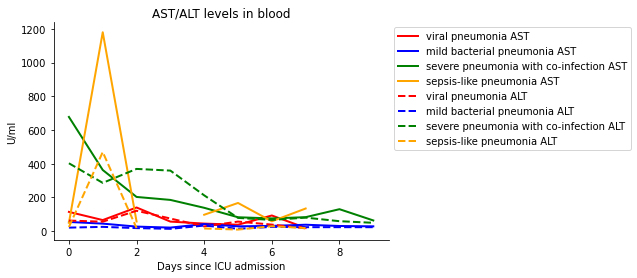

In [17]:
# Define the line styles and colors for each group of columns
line_styles = {'AST': '-', 'ALT': '--'}
line_colors = {
    'viral': 'red', 'mild': 'blue',
    'severe': 'green', 'sepsis-like': 'orange'
}

# Split columns into groups based on AST and ALT
ast_cols = [col for col in merged_transaminases.columns if 'AST' in col]
alt_cols = [col for col in merged_transaminases.columns if 'ALT' in col]

# Turn off Seaborn whitegrid style
plt.style.use('default')

ax = merged_transaminases.head(10)[ast_cols].plot(kind='line', style=[line_styles['AST']]*len(ast_cols), linewidth=2,
                       color=[line_colors[col.split(' ')[0]] for col in ast_cols], legend=False)

merged_transaminases.head(10)[alt_cols].plot(kind='line', style=[line_styles['ALT']]*len(alt_cols), linewidth=2,
                  color=[line_colors[col.split(' ')[0]] for col in alt_cols], ax=ax, legend=False)

plt.xlabel('Days since ICU admission')
plt.ylabel('U/ml')
plt.title('AST/ALT levels in blood')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Add a separate legend outside the plot to avoid overlapping
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('ast_alt.png', dpi=300,bbox_inches='tight')
plt.show()


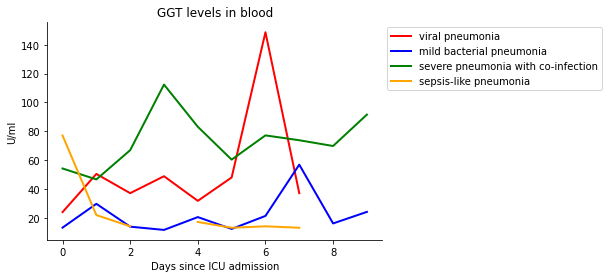

In [18]:
# Define the line colors for each column
line_colors = {'viral pneumonia': 'red', 'mild bacterial pneumonia': 'blue',
               'severe pneumonia with co-infection': 'green', 'sepsis-like pneumonia': 'orange'}

# Plot the data using pandas plot function
ax = merged_ggt.head(10).plot(kind='line',linewidth=2, color=[line_colors[col] for col in merged_ggt.columns])

# Turn off Seaborn whitegrid style
plt.style.use('default')
# Set labels and title
plt.xlabel('Days since ICU admission')
plt.ylabel('U/ml')
plt.title('GGT levels in blood')
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Show the legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.savefig('ggt.png', dpi=300, bbox_inches='tight')
plt.show()

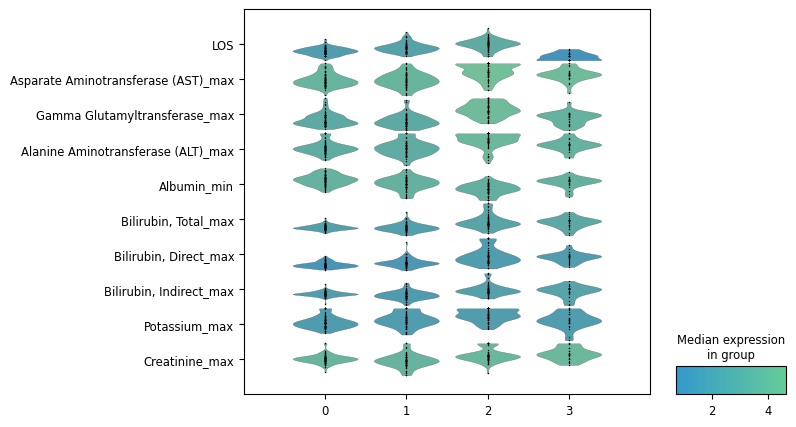

<Figure size 640x480 with 0 Axes>

In [36]:
from matplotlib.colors import LinearSegmentedColormap
start_color = '#FF0000'
start_color = '#3399CC'
end_color = '#66CC99'

# Create a custom color map with the gradient
cmap = LinearSegmentedColormap.from_list('custom_cmap', [start_color, end_color])

ep.pl.stacked_violin(adata, var_names=['LOS', "Asparate Aminotransferase (AST)_max",
                                      "Gamma Glutamyltransferase_max","Alanine Aminotransferase (ALT)_max", 
                                       "Albumin_min","Bilirubin, Total_max","Bilirubin, Direct_max", 
                                       "Bilirubin, Indirect_max","Potassium_max", "Creatinine_max"], 
                     groupby="leiden_0_6", figsize=(7,5), swap_axes = True, stripplot=True, cmap=cmap,save="violin_liver.png")
plt.tight_layout()

plt.show()

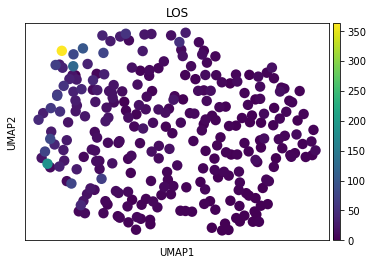

In [81]:
ep.pl.umap(adata, color="LOS", layer="original")

In [1]:
adata

NameError: name 'adata' is not defined